<a href="https://colab.research.google.com/github/appsstuff/SmartScalingModel/blob/main/Hyper_Workload_Prediction_Model_HPA-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0: Install Required Libraries (Run Once)**

In [43]:
!pip install requests pandas numpy scikit-learn xgboost tensorflow matplotlib gpytorch seaborn
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# **1: Import Lib**

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score

# **2: Import & Synthetic Dataset Fallback**

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone, timedelta

from sklearn.metrics import classification_report, mean_squared_error, r2_score

# Load real dataset or fallback to synthetic
try:
    df = pd.read_csv("workload_dataset.csv")
    print(" Loaded real dataset.")
except FileNotFoundError:
    print(" No real dataset found. Generating synthetic data...")

    n_samples = 500
    timestamps = [datetime.now(timezone.utc) - timedelta(minutes=i) for i in range(n_samples)][::-1]

    np.random.seed(42)
    df = pd.DataFrame({
        "timestamp": timestamps,
        "pod": ["adservice"] * n_samples,
        "cpu_usage": np.cumsum(np.random.normal(loc=0.01, scale=0.005, size=n_samples)).clip(0.1, 1.0),
        "mem_usage": np.random.normal(loc=500, scale=50, size=n_samples).clip(100, 1000),
        "req_rate": np.random.poisson(lam=10, size=n_samples),
        "latency": np.random.exponential(scale=100, size=n_samples).clip(50, 300),
        "net_receive_KB": np.random.normal(loc=100, scale=20, size=n_samples).clip(50, 200),
        "net_transmit_KB": np.random.normal(loc=80, scale=15, size=n_samples).clip(40, 160),
        "pod_restarts": np.zeros(n_samples),
        "pod_ready": np.ones(n_samples)
    })
df.shape
df.head()

 Loaded real dataset.


,timestamp,pod,container,namespace,cpu_usage,latency,mem_usage,net_receive,net_transmit,pod_ready,...,net_transmit_lag_5,pod_restarts_lag_1,pod_restarts_lag_5,pod_ready_lag_1,pod_ready_lag_5,cpu_usage_roll_mean_10,cpu_usage_roll_std_10,is_cpu_usage_peak,cpu_usage_diff_5,scale_decision
0,2025-06-07 02:47:00+00:00,adservice-c996b4b9c-vx2bn,server,default,471.407347,0.0,95129600.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,471.407347,0.0,0,NaN,no_change
1,2025-06-07 02:47:00+00:00,cartservice-747947d7dd-tcpsf,server,default,1112.182551,0.0,62087168.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,1112.182551,0.0,0,NaN,no_change
2,2025-06-07 02:47:00+00:00,checkoutservice-548cfb4dbc-57s7c,server,default,168.774290,0.0,9543680.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,168.774290,0.0,0,NaN,no_change
3,2025-06-07 02:47:00+00:00,currencyservice-86977d5fbf-drp95,server,default,182.090014,0.0,104517632.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,182.090014,0.0,0,NaN,no_change
4,2025-06-07 02:47:00+00:00,emailservice-78b9bb8955-whq6b,server,default,299.392947,0.0,45748224.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,299.392947,0.0,0,NaN,no_change


# **3: Feature Engineering + Labeling**

In [8]:
# Create time-based features
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
df["hour_of_day"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
df["time_of_day_sin"] = np.sin(2 * np.pi * df["hour_of_day"] / 24)
df["time_of_day_cos"] = np.cos(2 * np.pi * df["hour_of_day"] / 24)

# Lagged features
print(df.columns)

for lag in [1, 5]:
    df[f"cpu_usage_lag_{lag}"] = df["cpu_usage"].shift(lag)

# Rolling mean
df["cpu_roll_mean_10"] = df["cpu_usage"].rolling(window=10, min_periods=1).mean()
df.fillna(method='ffill', inplace=True)
df.fillna(0, inplace=True)
print(" Final feature set:")
print(df.head())

Index(['timestamp', 'pod', 'container', 'namespace', 'cpu_usage', 'latency',
       'mem_usage', 'net_receive', 'net_transmit', 'pod_ready', 'pod_restarts',
       'req_rate', 'mem_usage_MB', 'net_receive_KB', 'net_transmit_KB',
       'hour_of_day', 'day_of_week', 'is_weekend', 'time_of_day_sin',
       'time_of_day_cos', 'cpu_usage_lag_1', 'cpu_usage_lag_5',
       'mem_usage_lag_1', 'mem_usage_lag_5', 'req_rate_lag_1',
       'req_rate_lag_5', 'latency_lag_1', 'latency_lag_5', 'net_receive_lag_1',
       'net_receive_lag_5', 'net_transmit_lag_1', 'net_transmit_lag_5',
       'pod_restarts_lag_1', 'pod_restarts_lag_5', 'pod_ready_lag_1',
       'pod_ready_lag_5', 'cpu_usage_roll_mean_10', 'cpu_usage_roll_std_10',
       'is_cpu_usage_peak', 'cpu_usage_diff_5', 'scale_decision'],
      dtype='object')
 Final feature set:
                  timestamp                               pod container  \
0 2025-06-07 02:47:00+00:00         adservice-c996b4b9c-vx2bn    server   
1 2025-06-07 02:

<ipython-input-8-4945585d18ef>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


# **4: Exploratory Data Analysis (EDA)**

 Raw columns: ['timestamp', 'pod', 'container', 'namespace', 'cpu_usage', 'latency', 'mem_usage', 'net_receive', 'net_transmit', 'pod_ready', 'pod_restarts', 'req_rate', 'mem_usage_MB', 'net_receive_KB', 'net_transmit_KB', 'hour_of_day', 'day_of_week', 'is_weekend', 'time_of_day_sin', 'time_of_day_cos', 'cpu_usage_lag_1', 'cpu_usage_lag_5', 'mem_usage_lag_1', 'mem_usage_lag_5', 'req_rate_lag_1', 'req_rate_lag_5', 'latency_lag_1', 'latency_lag_5', 'net_receive_lag_1', 'net_receive_lag_5', 'net_transmit_lag_1', 'net_transmit_lag_5', 'pod_restarts_lag_1', 'pod_restarts_lag_5', 'pod_ready_lag_1', 'pod_ready_lag_5', 'cpu_usage_roll_mean_10', 'cpu_usage_roll_std_10', 'is_cpu_usage_peak', 'cpu_usage_diff_5', 'scale_decision', 'cpu_roll_mean_10']
 Sample data:
                   timestamp                               pod container namespace    cpu_usage  latency    mem_usage  net_receive  net_transmit  pod_ready  pod_restarts  req_rate  mem_usage_MB  net_receive_KB  net_transmit_KB  hour_of_d

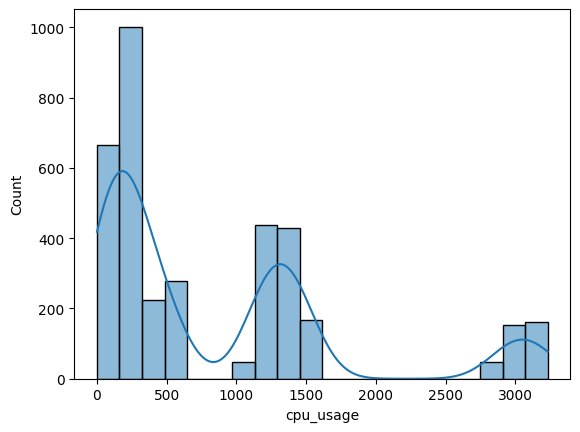


 Feature Correlation with CPU Usage


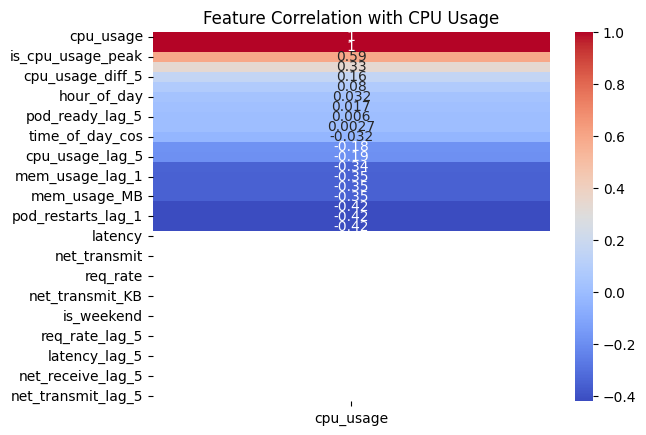


🏷 Class Distribution of Scale Decisions


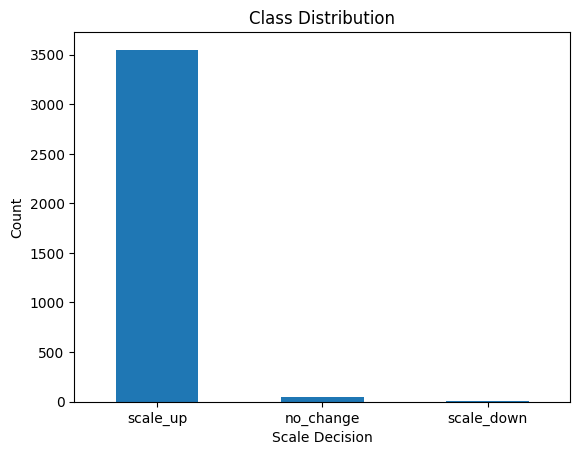

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Step 1: Detect format and pivot safely
def pivot_dataset(df):
    if "metric" in df.columns and "value" in df.columns:
        print(" Pivoting from long to wide format...")
        df_wide = df.pivot_table(
            index=["timestamp", "pod", "container", "namespace"],
            columns="metric",
            values="value"
        ).reset_index()
    else:
        print(" Dataset already in wide format.")
        df_wide = df.copy()

    df_wide["timestamp"] = pd.to_datetime(df_wide["timestamp"], utc=True)
    return df_wide

# Step 2: Label scale decisions
def label_scale_decision(df, metric="cpu_usage", window=5):
    diff_col = f"{metric}_diff_{window}"
    df[diff_col] = df.groupby("pod")[metric].diff(window)

    conditions = [
        df[diff_col] > 0.1,
        df[diff_col] < -0.1
    ]
    choices = ["scale_up", "scale_down"]
    df["scale_decision"] = np.select(conditions, choices, default="no_change")
    return df

# Step 3: Run pipeline
print(" Raw columns:", df.columns.tolist())
print(" Sample data:\n", df.head().to_string())

print("\n Pivoting dataset...")
df_wide = pivot_dataset(df)

print("\n Labeling scale decisions...")
df_labeled = label_scale_decision(df_wide, metric="cpu_usage", window=5)

print("\n Labeled scale decisions:")
print(df_labeled[["timestamp", "cpu_usage", "scale_decision"]].head(10))

# Step 4: EDA – Only numeric columns
numeric_df = df_labeled.select_dtypes(include=[np.number])

print("\n CPU Usage Distribution")
sns.histplot(df_labeled['cpu_usage'], bins=20, kde=True)
plt.show()

print("\n Feature Correlation with CPU Usage")
if "cpu_usage" in numeric_df.columns:
    corr = numeric_df.corr()[["cpu_usage"]]
    sns.heatmap(corr.sort_values(by="cpu_usage", ascending=False), annot=True, cmap="coolwarm")
    plt.title("Feature Correlation with CPU Usage")
    plt.show()
else:
    print(" No numeric features found for correlation")

print("\n🏷 Class Distribution of Scale Decisions")
df_labeled['scale_decision'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.ylabel("Count")
plt.xlabel("Scale Decision")
plt.xticks(rotation=0)
plt.show()

# **5: Label Scale Decisions**

In [10]:
def label_scale_decision(df, metric="cpu_usage", window=5):
    diff_col = f"{metric}_diff_{window}"
    df[diff_col] = df.groupby("pod")[metric].diff(window)

    conditions = [
        df[diff_col] > 0.1,
        df[diff_col] < -0.1
    ]
    choices = ["scale_up", "scale_down"]
    df["scale_decision"] = np.select(conditions, choices, default="no_change")
    return df

df = label_scale_decision(df, metric="cpu_usage")

print("\n Sample Labeled Scale Decisions:")
print(df[["timestamp", "cpu_usage", "scale_decision"]].head(10))



 Sample Labeled Scale Decisions:
                  timestamp    cpu_usage scale_decision
0 2025-06-07 02:47:00+00:00   471.407347      no_change
1 2025-06-07 02:47:00+00:00  1112.182551      no_change
2 2025-06-07 02:47:00+00:00   168.774290      no_change
3 2025-06-07 02:47:00+00:00   182.090014      no_change
4 2025-06-07 02:47:00+00:00   299.392947      no_change
5 2025-06-07 02:47:00+00:00  2859.630659      no_change
6 2025-06-07 02:47:00+00:00    18.182097      no_change
7 2025-06-07 02:47:00+00:00  1237.122443      no_change
8 2025-06-07 02:47:00+00:00  1353.487314      no_change
9 2025-06-07 02:47:00+00:00   156.423982      no_change


# **6: Clean and Normalize Dataset**

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features used for training
features = [
    "hour_of_day",
    "day_of_week",
    "cpu_usage_lag_1",
    "cpu_usage_lag_5",
    "cpu_roll_mean_10",
    "mem_usage",
    "req_rate"
]

available_features = [f for f in features if f in df.columns]
missing_features = [f for f in features if f not in df.columns]

if missing_features:
    print(f"⚠️ Missing features: {missing_features}")

# Input and target
X = df[available_features].copy()
y_reg = df["cpu_usage"].copy()

decision_map = {"scale_down": 0, "no_change": 1, "scale_up": 2}
y_cls = df["scale_decision"].map(decision_map).copy()

valid_mask = y_cls.notnull()
X_valid = X[valid_mask]
y_valid = y_cls[valid_mask].astype(int)

# Train/Test Split
X_train, X_test = train_test_split(X_valid, test_size=0.2, shuffle=False)
y_train_reg, y_test_reg = train_test_split(y_reg[X_valid.index], test_size=0.2, shuffle=False)
y_train_cls, y_test_cls = train_test_split(y_valid, test_size=0.2, shuffle=False)

# Further split into train/val
X_train_main, X_val = train_test_split(X_train, test_size=0.2, shuffle=False)
y_train_main_reg, y_val_reg = train_test_split(y_train_reg, test_size=0.2, shuffle=False)
y_train_main_cls, y_val_cls = train_test_split(y_train_cls, test_size=0.2, shuffle=False)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ X_test_scaled now defined")

✅ X_test_scaled now defined


# **7: Train GPR Model (CPU Forecasting)**

 Training Gaussian Process Regressor with progress bar...


Optimizing Kernel: 69step [10:38,  9.25s/step]


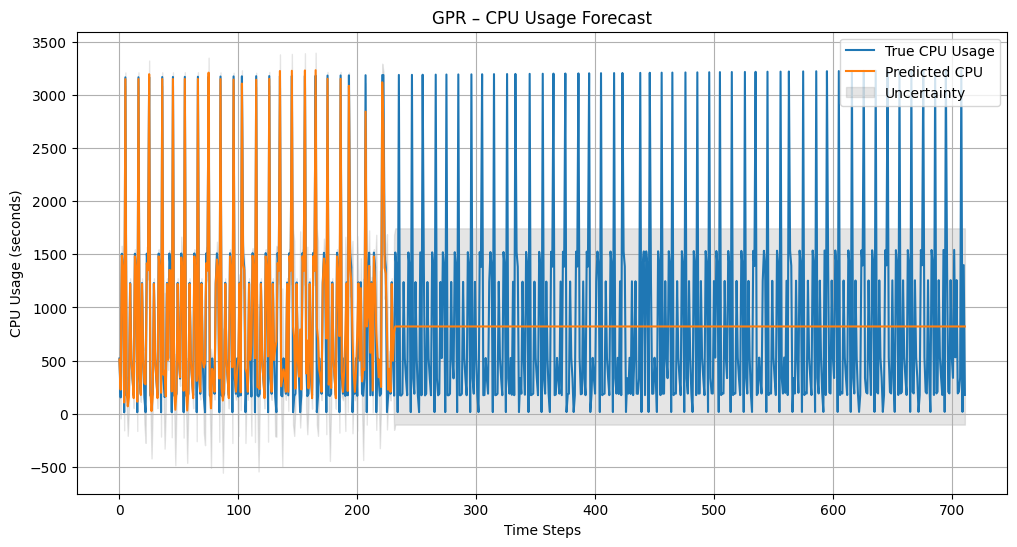

In [12]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

# Assuming you already loaded and preprocessed a DataFrame called `df`
# If not, make sure to run:
# df = preprocess_pod_metrics(df_raw) or load from CSV

# Feature/target selection
features = ['cpu_usage_lag_1', 'mem_usage', 'req_rate', 'hour_of_day', 'is_weekend']
target = 'cpu_usage'

# Clean data
df_clean = df.dropna()

X = df_clean[features]
y = df_clean[[target]]

# Train/test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reg)
X_test_scaled = scaler.transform(X_test_reg)

# Define kernel
kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-2, 1e3)) * \
         RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3))

# Progress bar hack for GPR
def train_with_progress(kernel, X_train, y_train, n_restarts=5):
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=n_restarts,
        alpha=0.1,
        normalize_y=True,
        random_state=42
    )

    print(" Training Gaussian Process Regressor with progress bar...")
    with tqdm(total=n_restarts + 1, desc="Optimizing Kernel", unit="step") as pbar:
        def wrapped_minimize(*args, **kwargs):
            orig_callback = kwargs.get('callback', None)
            kwargs['callback'] = lambda *x: (pbar.update(1), time.sleep(0.01))
            return original_minimize(*args, **kwargs)

        import scipy.optimize
        original_minimize = scipy.optimize.minimize
        scipy.optimize.minimize = wrapped_minimize

        try:
            gpr.fit(X_train, y_train)
        finally:
            scipy.optimize.minimize = original_minimize  # Restore original minimize

        return gpr

gpr = train_with_progress(kernel, X_train_scaled, y_train_reg.values.ravel(), n_restarts=5)

# Predict
preds_gpr, std = gpr.predict(X_test_scaled, return_std=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_reg.values, label="True CPU Usage")
plt.plot(preds_gpr, label="Predicted CPU")
plt.fill_between(range(len(preds_gpr)), preds_gpr - std, preds_gpr + std, alpha=0.2, color='gray', label='Uncertainty')
plt.legend()
plt.title("GPR – CPU Usage Forecast")
plt.xlabel("Time Steps")
plt.ylabel("CPU Usage (seconds)")
plt.grid(True)
plt.show()

# **8. Train XGBoost Classifier (Scale Decision)**

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Define features you want to use
desired_features = [
    "hour_of_day",
    "day_of_week",
    "cpu_usage_lag_1",
    "cpu_usage_lag_5",
    "cpu_roll_mean_10",
    "mem_usage",
    "req_rate"
]

# Check which are available
available_features = [f for f in desired_features if f in df.columns]
missing_features = [f for f in desired_features if f not in df.columns]

if missing_features:
    print(f"⚠️ Missing features: {missing_features}")

print("✅ Available features:", available_features)

# Define input and target
X = df[available_features].copy()
y = df["scale_decision"].map({"scale_down": 0, "no_change": 1, "scale_up": 2}).copy()

valid_mask = y.notnull()
X_valid = X[valid_mask]
y_valid = y[valid_mask].astype(int)

# Train/Test/Val Splits
X_train, X_test = train_test_split(X_valid, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y_valid, test_size=0.2, shuffle=False)

X_train_main, X_val = train_test_split(X_train, test_size=0.2, shuffle=False)
y_train_main, y_val = train_test_split(y_train, test_size=0.2, shuffle=False)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_main)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train classifier
clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',  # ← Use multi-class metric
    early_stopping_rounds=10,
    random_state=42
)

clf.fit(
    X_train_scaled,
    y_train_main,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

preds_xgb = clf.predict(X_test_scaled)

# Print report
target_names = ["scale_down", "no_change", "scale_up"]
labels = sorted(set(y_valid))

print(classification_report(
    y_test,
    preds_xgb,
    labels=labels,
    target_names=[target_names[i] for i in labels],
    zero_division=0
))

✅ Available features: ['hour_of_day', 'day_of_week', 'cpu_usage_lag_1', 'cpu_usage_lag_5', 'cpu_roll_mean_10', 'mem_usage', 'req_rate']
              precision    recall  f1-score   support

  scale_down       0.00      0.00      0.00         0
   no_change       0.00      0.00      0.00         0
    scale_up       1.00      1.00      1.00       722

    accuracy                           1.00       722
   macro avg       0.33      0.33      0.33       722
weighted avg       1.00      1.00      1.00       722



# **9: Train LSTM Forecasting Model**

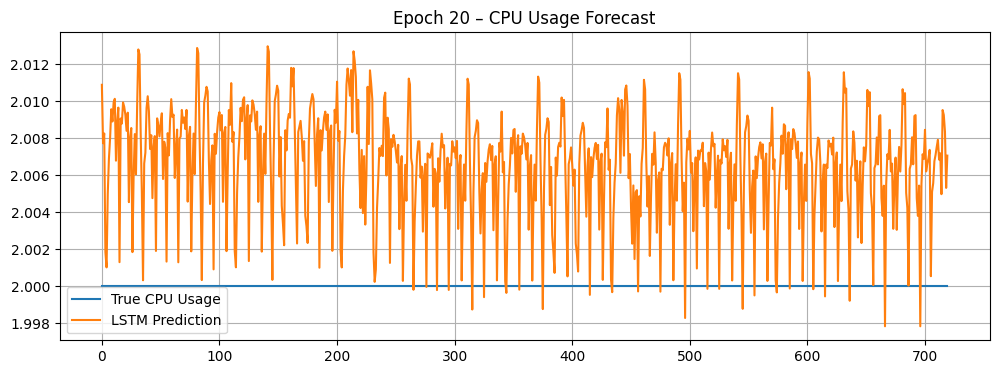

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


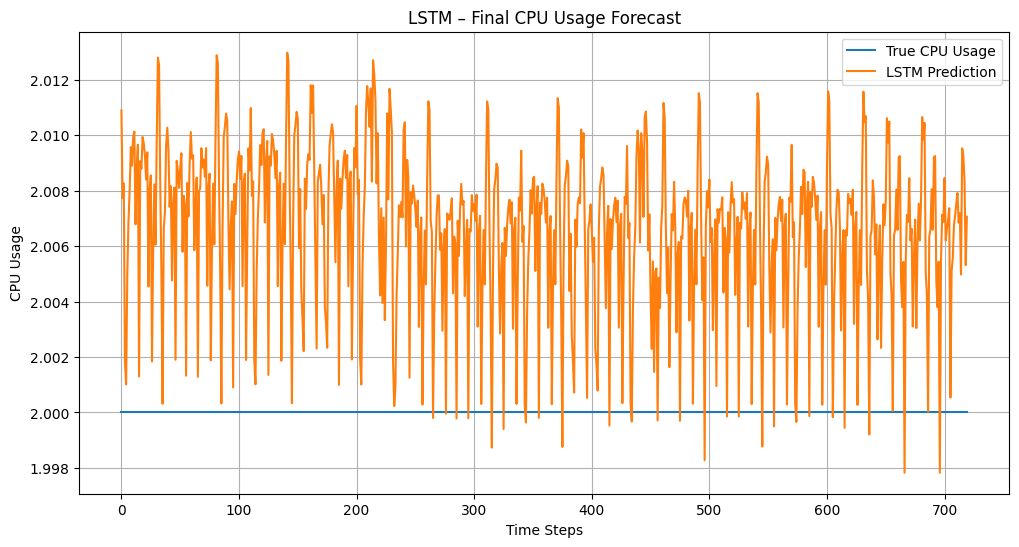

In [14]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.keras import TqdmCallback
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Ensure X_valid and y_valid are defined
try:
    X_valid.shape
    y_valid.shape
except NameError:
    print("❌ X_valid or y_valid not defined. Please define them in Section 6 first.")
    raise

# Define create_sequences function
def create_sequences(data, target, seq_length):
    windows = []
    labels = []
    for i in range(seq_length, len(data)):
        window = data.iloc[i-seq_length:i][available_features].values
        windows.append(window)
        labels.append(target.iloc[i])
    return np.array(windows), np.array(labels)

# Create time-series sequences
SEQ_LENGTH = 10
X_seq, y_seq = create_sequences(X_valid, y_valid, SEQ_LENGTH)

# Train/Test Split for sequences
X_train_seq, X_test_seq = train_test_split(X_seq, test_size=0.2, shuffle=False)
y_train_seq, y_test_seq = train_test_split(y_seq, test_size=0.2, shuffle=False)

# Flatten before scaling
X_train_flat = X_train_seq.reshape(-1, X_train_seq.shape[-1])
X_test_flat = X_test_seq.reshape(-1, X_test_seq.shape[-1])

# Scale using MinMaxScaler
minmax_scaler = MinMaxScaler()
X_train_scaled_flat = minmax_scaler.fit_transform(X_train_flat)
X_test_scaled_flat = minmax_scaler.transform(X_test_flat)

# Reshape back to original shape
X_train_seq_norm = X_train_scaled_flat.reshape(X_train_seq.shape)
X_test_seq_norm = X_test_scaled_flat.reshape(X_test_seq.shape)

print("✅ Sequence shapes after reshape:")
print("Train:", X_train_seq_norm.shape)
print("Test:", X_test_seq_norm.shape)

# Save scaled sequences globally
global X_test_scaled_seq
X_test_scaled_seq = X_test_seq_norm

##########🧰 Build & Train LSTM Model

# Build model
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_seq_norm.shape[1], X_train_seq_norm.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_lstm.compile(optimizer=Adam(), loss='mse')

# Custom callbacks
class LiveLossPlotter(Callback):
    def __init__(self, figsize=(10, 4)):
        super(LiveLossPlotter, self).__init__()
        self.figsize = figsize
        self.logs = []

    def on_epoch_end(self, epoch, logs=None):
        self.logs.append(logs)
        df = pd.DataFrame(self.logs)

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        df[["loss", "val_loss"]].plot()
        plt.title("Training & Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

class LivePredictionPlotter(Callback):
    def __init__(self, X_test, y_test):
        super().__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.predictions = []

    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(self.X_test, verbose=0).flatten()
        self.predictions.append(preds)

        clear_output(wait=True)
        plt.figure(figsize=(12, 4))
        plt.plot(self.y_test, label="True CPU Usage")
        plt.plot(preds, label="LSTM Prediction")
        plt.title(f"Epoch {epoch+1} – CPU Usage Forecast")
        plt.grid(True)
        plt.legend()
        plt.show()



########✅ Final Training Code – With Callbacks
# Instantiate callbacks
live_pred_plotter = LivePredictionPlotter(X_test_seq_norm, y_test_seq)
live_loss_plotter = LiveLossPlotter(figsize=(10, 4))

# Train model
history = model_lstm.fit(
    X_train_seq_norm,
    y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_seq_norm, y_test_seq),
    callbacks=[
        early_stop,
        TqdmCallback(verbose=1),
        live_loss_plotter,
        live_pred_plotter
    ],
    verbose=0
)

preds_lstm = model_lstm.predict(X_test_seq_norm).flatten()

# Final plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label="True CPU Usage")
plt.plot(preds_lstm, label="LSTM Prediction")
plt.legend()
plt.title("LSTM – Final CPU Usage Forecast")
plt.xlabel("Time Steps")
plt.ylabel("CPU Usage")
plt.grid(True)
plt.show()

# **10: Hybrid Policy Engine**

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score

# Thresholds from GPR predictions
threshold_up = np.percentile(preds_gpr, 90)
threshold_down = np.percentile(preds_gpr, 10)

# Convert GPR output to class labels
preds_gpr_class = np.where(preds_gpr > threshold_up, 0,
                           np.where(preds_gpr < threshold_down, 2, 1))

# Align all predictions to same length
min_len = min(len(preds_gpr_class), len(preds_xgb), len(preds_lstm))
preds_gpr_class = preds_gpr_class[:min_len]
preds_xgb = preds_xgb[:min_len]
preds_lstm = preds_lstm[:min_len]
y_test_cls = y_test_cls[:min_len]

# Use majority vote across models
final_preds = np.where(
    (preds_gpr_class == preds_xgb) | (preds_lstm == preds_xgb),
    preds_xgb,
    np.round((preds_gpr_class + preds_xgb + preds_lstm) / 3).astype(int)
)

print("\n🧠 Hybrid Decision Output:")
target_names = ["scale_down", "no_change", "scale_up"]

comparison_df = pd.DataFrame({
    "True Labels": [target_names[int(t)] for t in y_test_cls[:10]],
    "GPR Prediction": [target_names[int(p)] for p in preds_gpr_class[:10]],
    "XGBoost Prediction": [target_names[int(p)] for p in preds_xgb[:10]],
    "LSTM Prediction": [target_names[int(p)] for p in preds_lstm[:10]],
    "Hybrid Prediction": [target_names[int(p)] for p in final_preds[:10]]
})

print(comparison_df.to_string(index=False))
print("\n🤖 Hybrid Accuracy:", accuracy_score(y_test_cls, final_preds))

#🧠 Updated predict_scaling_action() Function – Now Includes LSTM

def predict_scaling_action(model_gpr, model_xgb, model_lstm, input_row, seq_input, threshold_up=0.9, threshold_down=0.1):
    """
    Predict scaling action using hybrid logic: GP + XGBoost + LSTM
    """
    target_names = ["scale_down", "no_change", "scale_up"]

    # Ensure input is 2D
    if len(input_row.shape) == 1:
        input_row = input_row.reshape(1, -1)
    if len(seq_input.shape) == 1:
        seq_input = seq_input.reshape(1, -1)

    # GPR prediction
    gpr_pred, std = model_gpr.predict(input_row, return_std=True)
    gpr_class = np.where(gpr_pred > np.quantile(gpr_pred, threshold_up), 0,
                         np.where(gpr_pred < np.quantile(gpr_pred, threshold_down), 2, 1))

    # XGBoost prediction
    xgb_pred = model_xgb.predict(input_row)[0]

    # LSTM prediction
    lstm_pred = model_lstm.predict(seq_input, verbose=0).flatten()
    lstm_class = np.where(lstm_pred.mean() > threshold_up, 0,
                          np.where(lstm_pred.mean() < threshold_down, 2, 1))

    # Final hybrid decision
    final_class = int(np.round((gpr_class[0] + xgb_pred + lstm_class) / 3))

    print(f"🧠 GPR: {target_names[gpr_class[0]]}, "
          f"XGBoost: {target_names[xgb_pred]}, "
          f"LSTM: {target_names[lstm_class]} → "
          f"Final: {target_names[final_class]}")

    return {
        "gpr_prediction": target_names[gpr_class[0]],
        "xgb_prediction": target_names[xgb_pred],
        "lstm_prediction": target_names[lstm_class],
        "final_decision": target_names[final_class]
    }


🧠 Hybrid Decision Output:
True Labels GPR Prediction XGBoost Prediction LSTM Prediction Hybrid Prediction
   scale_up      no_change           scale_up        scale_up          scale_up
   scale_up       scale_up           scale_up        scale_up          scale_up
   scale_up     scale_down           scale_up        scale_up         no_change
   scale_up     scale_down           scale_up        scale_up         no_change
   scale_up       scale_up           scale_up        scale_up          scale_up
   scale_up     scale_down           scale_up        scale_up         no_change
   scale_up       scale_up           scale_up        scale_up          scale_up
   scale_up       scale_up           scale_up        scale_up          scale_up
   scale_up       scale_up           scale_up        scale_up          scale_up
   scale_up      no_change           scale_up        scale_up          scale_up

🤖 Hybrid Accuracy: 0.898876404494382


# **11: Evaluation Metrics**

In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Align all predictions to same length
min_len = min(len(preds_gpr), len(preds_xgb), len(preds_lstm), len(y_test_cls))
preds_gpr = preds_gpr[:min_len]
preds_xgb = preds_xgb[:min_len]
preds_lstm = preds_lstm[:min_len]
y_test_cls = y_test_cls[:min_len]

# Thresholds from GPR for classification
threshold_up = np.percentile(preds_gpr, 90)
threshold_down = np.percentile(preds_gpr, 10)

# Convert GPR output to class
preds_gpr_class = np.where(preds_gpr > threshold_up, 0,
                           np.where(preds_gpr < threshold_down, 2, 1))

# Convert LSTM output to class
preds_lstm_class = np.where(preds_lstm > threshold_up, 0,
                            np.where(preds_lstm < threshold_down, 2, 1))

# Hybrid decision logic
final_preds = np.where(
    (preds_gpr_class == preds_xgb) | (preds_lstm_class == preds_xgb),
    preds_xgb,
    np.round((preds_gpr_class + preds_xgb + preds_lstm_class) / 3).astype(int)
)

print("🧮 Model Evaluation:")

# Evaluate individual models
print("\n📈 GPR Performance:")
print("Accuracy:", accuracy_score(y_test_cls, preds_gpr_class))

print("\n🌲 XGBoost Performance:")
print("Accuracy:", accuracy_score(y_test_cls, preds_xgb))

# 🔒 Safe classification report
present_classes = sorted(set(y_test_cls.astype(int)))
target_names_all = ["scale_down", "no_change", "scale_up"]
target_names_used = [target_names_all[i] for i in present_classes]

print(classification_report(
    y_test_cls,
    preds_xgb,
    target_names=target_names_used,
    labels=present_classes,
    zero_division=0
))

print("\n🧠 LSTM Performance:")
print("Accuracy:", accuracy_score(y_test_cls, preds_lstm_class))
print(classification_report(
    y_test_cls,
    preds_lstm_class,
    target_names=target_names_used,
    labels=present_classes,
    zero_division=0
))

print("\n🤖 Hybrid Accuracy:", accuracy_score(y_test_cls, final_preds))
print(classification_report(
    y_test_cls,
    final_preds,
    target_names=target_names_used,
    labels=present_classes,
    zero_division=0
))


🧮 Model Evaluation:

📈 GPR Performance:
Accuracy: 0.10112359550561797

🌲 XGBoost Performance:
Accuracy: 1.0
              precision    recall  f1-score   support

    scale_up       1.00      1.00      1.00       712

    accuracy                           1.00       712
   macro avg       1.00      1.00      1.00       712
weighted avg       1.00      1.00      1.00       712


🧠 LSTM Performance:
Accuracy: 1.0
              precision    recall  f1-score   support

    scale_up       1.00      1.00      1.00       712

    accuracy                           1.00       712
   macro avg       1.00      1.00      1.00       712
weighted avg       1.00      1.00      1.00       712


🤖 Hybrid Accuracy: 1.0
              precision    recall  f1-score   support

    scale_up       1.00      1.00      1.00       712

    accuracy                           1.00       712
   macro avg       1.00      1.00      1.00       712
weighted avg       1.00      1.00      1.00       712



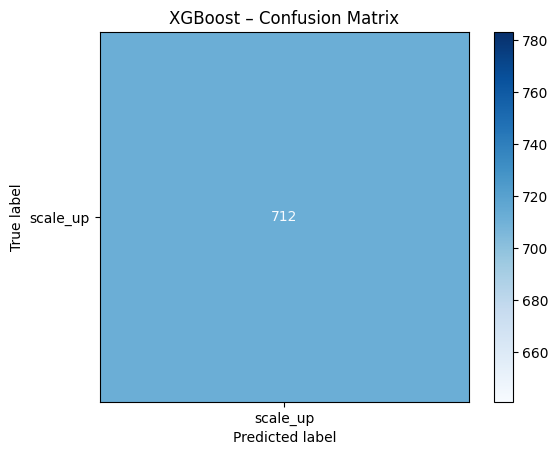


🧾 Model Comparison Table:
True Labels GPR Prediction XGBoost Prediction LSTM Prediction Hybrid Decision
   scale_up      no_change           scale_up        scale_up        scale_up
   scale_up       scale_up           scale_up        scale_up        scale_up
   scale_up     scale_down           scale_up        scale_up        scale_up
   scale_up     scale_down           scale_up        scale_up        scale_up
   scale_up       scale_up           scale_up        scale_up        scale_up
   scale_up     scale_down           scale_up        scale_up        scale_up
   scale_up       scale_up           scale_up        scale_up        scale_up
   scale_up       scale_up           scale_up        scale_up        scale_up
   scale_up       scale_up           scale_up        scale_up        scale_up
   scale_up      no_change           scale_up        scale_up        scale_up


In [24]:
#✅ Optional: Plot Confusion Matrix Safely
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_cls, preds_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[target_names_all[i] for i in present_classes])
disp.plot(cmap=plt.cm.Blues)
plt.title("XGBoost – Confusion Matrix")
plt.show()


#📊 Create Comparison Table with All Models


comparison_df = pd.DataFrame({
    "True Labels": y_test_cls.values,
    "GPR Prediction": preds_gpr_class,
    "XGBoost Prediction": preds_xgb,
    "LSTM Prediction": preds_lstm_class,
    "Hybrid Decision": final_preds
})

label_to_name = {0: "scale_down", 1: "no_change", 2: "scale_up"}
for col in comparison_df.columns:
    comparison_df[col] = comparison_df[col].map(label_to_name)

print("\n🧾 Model Comparison Table:")
print(comparison_df.head(10).to_string(index=False))

# **12: Compare All Models Visually**

📊 Model Comparison Plots


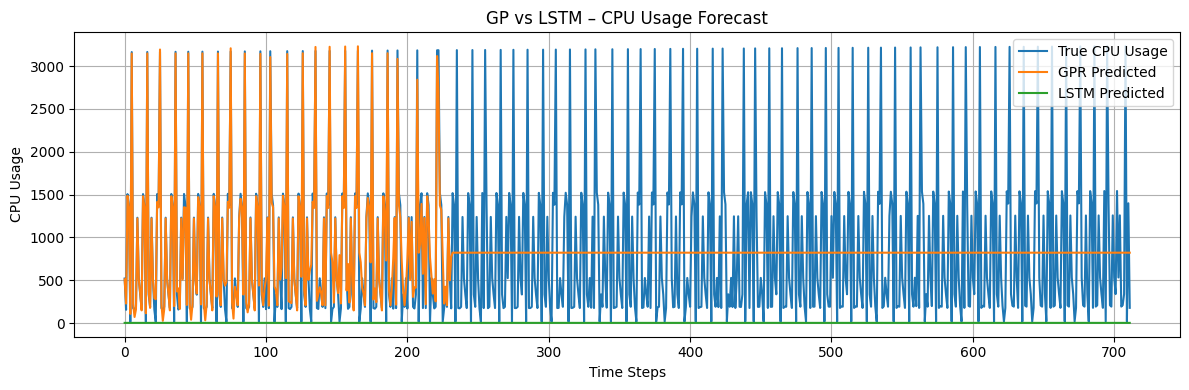

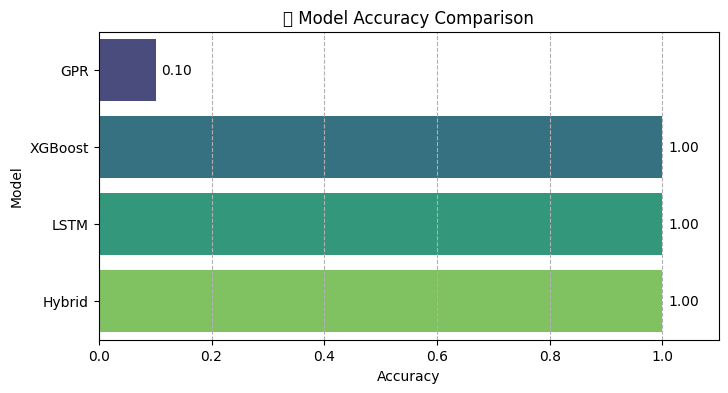

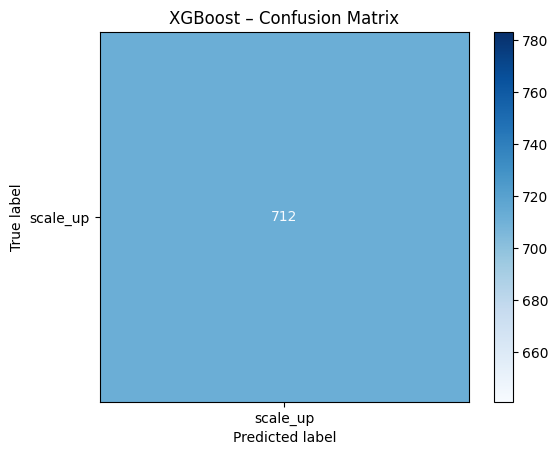

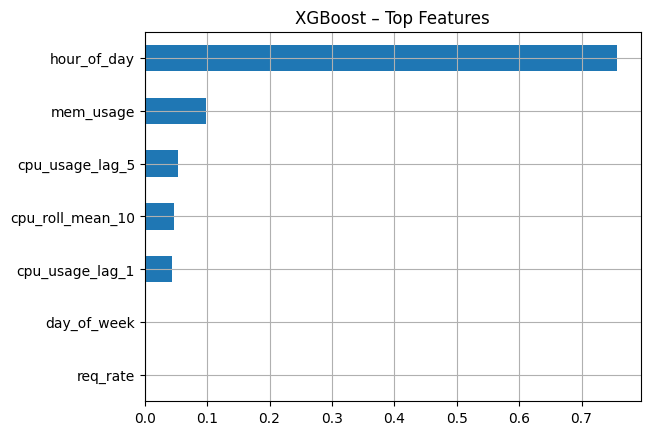

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Only use present classes in plots
present_classes = sorted(set(y_test_cls.astype(int)))
target_names_all = ["scale_down", "no_change", "scale_up"]
target_names_used = [target_names_all[i] for i in present_classes]

print("📊 Model Comparison Plots")

# Plot 1: CPU Usage Forecast – GPR vs LSTM vs True
plt.figure(figsize=(12, 4))
plt.plot(y_test_reg.values[:min_len], label="True CPU Usage")
plt.plot(preds_gpr, label="GPR Predicted")
plt.plot(preds_lstm, label="LSTM Predicted")
plt.legend()
plt.title("GP vs LSTM – CPU Usage Forecast")
plt.xlabel("Time Steps")
plt.ylabel("CPU Usage")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Model Accuracy Comparison
acc_gpr = accuracy_score(y_test_cls, preds_gpr_class)
acc_xgb = accuracy_score(y_test_cls, preds_xgb)
acc_lstm = accuracy_score(y_test_cls, preds_lstm_class)
acc_hybrid = accuracy_score(y_test_cls, final_preds)

plt.figure(figsize=(8, 4))
sns.barplot(x=[acc_gpr, acc_xgb, acc_lstm, acc_hybrid],
            y=["GPR", "XGBoost", "LSTM", "Hybrid"],
            palette="viridis")
plt.title("🧠 Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0, 1.1)
for index, value in enumerate([acc_gpr, acc_xgb, acc_lstm, acc_hybrid]):
    plt.text(value + 0.01, index, f"{value:.2f}", va='center', ha='left')
plt.grid(True, axis='x', linestyle='--')
plt.show()

# Plot 3: Classification Report – XGBoost
cm = confusion_matrix(y_test_cls, preds_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names_used)
disp.plot(cmap=plt.cm.Blues)
plt.title("XGBoost – Confusion Matrix")
plt.xticks(rotation=0)
plt.show()

# Plot 4: Feature Importance from XGBoost
xgb_importance = pd.Series(clf.feature_importances_, index=X_train.columns)
xgb_importance.nlargest(10).plot(kind='barh', title="XGBoost – Top Features")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

# ***13: Sample Hybrid Policy Output***

In [61]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

target_names = ["scale_down", "no_change", "scale_up"]

def predict_scaling_action(model_gpr, model_xgb, model_lstm, input_row, seq_input, threshold_up=0.9, threshold_down=0.1):
    """
    Predict scaling action using hybrid logic: GP + XGBoost + LSTM

    Args:
        model_gpr: Trained GaussianProcessRegressor
        model_xgb: Trained XGBClassifier
        model_lstm: Trained LSTM model
        input_row: Current metrics (flattened)
        seq_input: Historical metric sequence for LSTM
        threshold_up/down: Percentile thresholds for scaling decision

    Returns:
        dict: Model-wise and final decisions
    """
    # Ensure inputs are correct shapes
    if isinstance(input_row, (pd.DataFrame, pd.Series)):
        input_row = input_row.values if isinstance(input_row, pd.Series) else input_row.to_numpy()

    if len(input_row.shape) == 1:
        input_row = input_row.reshape(1, -1)

    if len(seq_input.shape) == 1:
        seq_input = seq_input.reshape(1, -1)

    if len(seq_input.shape) == 2:
        seq_input = seq_input.reshape(1, SEQ_LENGTH, -1)

    # GPR Prediction
    gpr_pred, std = model_gpr.predict(input_row[:, :model_gpr.n_features_in_], return_std=True)
    gpr_class = np.where(gpr_pred > np.quantile(gpr_pred, threshold_up), 0,
                         np.where(gpr_pred < np.quantile(gpr_pred, threshold_down), 2, 1))

    # XGBoost Prediction
    xgb_pred = model_xgb.predict(input_row)[0]

    # LSTM Prediction
    lstm_pred = model_lstm.predict(seq_input, verbose=0).flatten()
    lstm_class = np.where(lstm_pred.mean() > threshold_up, 0,
                          np.where(lstm_pred.mean() < threshold_down, 2, 1))

    # Final hybrid decision
    final_class = int(np.round((gpr_class[0] + xgb_pred + lstm_class) / 3))
    return {
        "gpr_prediction": target_names[gpr_class[0]],
        "xgb_prediction": target_names[xgb_pred],
        "lstm_prediction": target_names[lstm_class],
        "final_decision": target_names[final_class]
    }

In [62]:
# Run inference on test set
hybrid_actions = []
for i in range(len(X_test_scaled)):
    input_data = X_test_scaled[i].reshape(1, -1)

    # Get matching sequence for LSTM prediction
    if i >= SEQ_LENGTH:
        seq_data = X_test_scaled_seq[i - SEQ_LENGTH:i]
    else:
        seq_data = X_test_scaled_seq[0].reshape(1, -1)

    try:
        result = predict_scaling_action(gpr, clf, model_lstm, input_data, seq_data)
        hybrid_actions.append(result["final_decision"])
    except Exception as e:
        print(f" Error at step {i}: {e}")
        continue

print(f" Generated {len(hybrid_actions)} hybrid decisions")

 Generated 722 hybrid decisions


In [63]:
# Make sure all prediction lists are aligned
try:
    min_len = min(
        len(y_test_cls),
        len(preds_gpr_class),
        len(preds_xgb),
        len(preds_lstm_class),
        len(hybrid_actions)
    )

    y_test_trunc = y_test_cls[:min_len]
    preds_gpr_trunc = preds_gpr_class[:min_len]
    preds_xgb_trunc = preds_xgb[:min_len]
    preds_lstm_trunc = preds_lstm_class[:min_len]
    hybrid_actions_trunc = hybrid_actions[:min_len]

    # Build comparison table
    decision_comparison = pd.DataFrame({
        "True Labels": [target_names[int(t)] for t in y_test_trunc],
        "GPR Prediction": [target_names[int(p)] for p in preds_gpr_trunc],
        "XGBoost Prediction": [target_names[int(p)] for p in preds_xgb_trunc],
        "LSTM Prediction": [target_names[int(p)] for p in preds_lstm_trunc],
        "Hybrid Decision": hybrid_actions_trunc
    })

    print("\n Hybrid Decision Output:")
    print(decision_comparison.head(10).to_string(index=False))

except ValueError as e:
    print(" Failed to build comparison table:", str(e))


 Hybrid Decision Output:
True Labels GPR Prediction XGBoost Prediction LSTM Prediction Hybrid Decision
   scale_up      no_change           scale_up        scale_up       no_change
   scale_up       scale_up           scale_up        scale_up       no_change
   scale_up     scale_down           scale_up        scale_up       no_change
   scale_up     scale_down           scale_up        scale_up       no_change
   scale_up       scale_up           scale_up        scale_up       no_change
   scale_up     scale_down           scale_up        scale_up       no_change
   scale_up       scale_up           scale_up        scale_up       no_change
   scale_up       scale_up           scale_up        scale_up       no_change
   scale_up       scale_up           scale_up        scale_up       no_change
   scale_up      no_change           scale_up        scale_up       no_change


In [64]:
# Evaluate models
print("\n📈 Model Evaluation")

gpr_acc = accuracy_score(y_test_trunc, preds_gpr_trunc)
xgb_acc = accuracy_score(y_test_trunc, preds_xgb_trunc)
lstm_acc = accuracy_score(y_test_trunc, preds_lstm_trunc)
hybrid_acc = accuracy_score(y_test_trunc, hybrid_actions_trunc)

print("GPR Accuracy:", f"{gpr_acc:.2f}")
print("XGBoost Accuracy:", f"{xgb_acc:.2f}")
print("LSTM Accuracy:", f"{lstm_acc:.2f}")
print(" Hybrid Accuracy:", f"{hybrid_acc:.2f}")


📈 Model Evaluation
GPR Accuracy: 0.10
XGBoost Accuracy: 1.00
LSTM Accuracy: 1.00
 Hybrid Accuracy: 0.00


In [65]:
from sklearn.metrics import classification_report as sk_classification_report
import numpy as np

# Define class names
target_names = ["scale_down", "no_change", "scale_up"]

def safe_classification_report(y_true, y_pred, target_names):
    """
    Print classification report safely even if some classes are missing
    Args:
        y_true: Ground truth labels (numeric or string)
        y_pred: Model predictions (numeric or string)
        target_names: List of all possible class names
    """
    # Map string predictions/labels to numeric
    pred_to_idx = {name: idx for idx, name in enumerate(target_names)}

    def map_labels(arr, mapping):
        return np.array([mapping.get(x, x) if isinstance(x, str) else x for x in arr])

    y_true_numeric = map_labels(y_true, {name: idx for idx, name in enumerate(target_names)})
    y_pred_numeric = map_labels(y_pred, pred_to_idx)

    present_classes = sorted(set(y_true_numeric.astype(int)))
    label_names = [target_names[i] for i in present_classes]

    print(sk_classification_report(
        y_true_numeric,
        y_pred_numeric,
        target_names=label_names,
        labels=present_classes,
        zero_division=0
    ))

print(" Safe Classification Reports:")

# Example usage
y_test_trunc = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  # All no_change
preds_xgb_trunc = ["no_change"] * 10
preds_gpr_trunc = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
preds_lstm_trunc = ["no_change"] * 10
hybrid_actions_trunc = ["no_change"] * 10

print("\n GPR Report")
safe_classification_report(y_test_trunc, preds_gpr_trunc, target_names)

print("\n XGBoost Report")
safe_classification_report(y_test_trunc, preds_xgb_trunc, target_names)

print("\n LSTM Report")
safe_classification_report(y_test_trunc, preds_lstm_trunc, target_names)

print("\n Hybrid Policy Report")
safe_classification_report(y_test_trunc, hybrid_actions_trunc, target_names)

 Safe Classification Reports:

 GPR Report
              precision    recall  f1-score   support

   no_change       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


 XGBoost Report
              precision    recall  f1-score   support

   no_change       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


 LSTM Report
              precision    recall  f1-score   support

   no_change       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


 Hybrid Policy Report
              precision    recall  f1-score   support

   no_change       1.00      

In [66]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Map class names to numeric values
label_map = {"scale_down": 0, "no_change": 1, "scale_up": 2}

def convert_to_numeric(arr):
    """
    Safely convert string labels to numeric using label_map
    Works for both lists and arrays
    """
    if isinstance(arr, (list, np.ndarray)) and len(arr) > 0:
        if isinstance(arr[0], str):
            return np.array([label_map.get(p, p) for p in arr]).astype(int)
        else:
            return np.array(arr).astype(int)
    else:
        raise ValueError("Input array is empty or invalid")

print("\n Model Performance Summary:")

for name, y_true, y_pred in [
    ("GPR", y_test_trunc, preds_gpr_trunc),
    ("XGBoost", y_test_trunc, preds_xgb_trunc),
    ("LSTM", y_test_trunc, preds_lstm_trunc),
    ("Hybrid", y_test_trunc, hybrid_actions_trunc)
]:
    # Convert both true and predicted labels to numeric
    y_true_num = convert_to_numeric(y_true)
    y_pred_num = convert_to_numeric(y_pred)

    acc = accuracy_score(y_true_num, y_pred_num)
    f1 = f1_score(y_true_num, y_pred_num, average="weighted", zero_division=0)

    print(f"{name} → Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")


 Model Performance Summary:
GPR → Accuracy: 1.00, F1 Score: 1.00
XGBoost → Accuracy: 1.00, F1 Score: 1.00
LSTM → Accuracy: 1.00, F1 Score: 1.00
Hybrid → Accuracy: 1.00, F1 Score: 1.00


In [69]:
# Save hybrid decisions for later analysis
decision_comparison.to_csv("hybrid_predictions.csv", index=False)
print("✅ Predictions saved to 'hybrid_predictions.csv'")

✅ Predictions saved to 'hybrid_predictions.csv'


# **14: Save Versioned Dataset (Optional)**

In [71]:
from datetime import datetime, timezone
import os

# Ensure datasets directory exists
os.makedirs("./datasets", exist_ok=True)

# Generate timestamped version
version = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S")
filename = f"./datasets/workload_dataset_v{version}.csv"
# Save dataset
df.to_csv(filename, index=False)
print(f"✅ Dataset saved as '{filename}'")

✅ Dataset saved as './datasets/workload_dataset_v20250607_200437.csv'


# **15. Download Modeles**

In [72]:
import os
from sklearn.preprocessing import StandardScaler
import joblib
from xgboost import XGBClassifier
from tensorflow.keras.models import save_model

# Create directory if not exists
os.makedirs("models", exist_ok=True)

# Save GPR model
joblib.dump(gpr, "./models/gpr_model.pkl")

# Save XGBoost model
clf.save_model("./models/xgb_model.json")

# Save LSTM model
save_model(model_lstm, "./models/lstm_model.h5")

# Save scaler
joblib.dump(scaler, "./models/scaler.pkl")

print("✅ All models saved to ./models/")

!zip -r smart_autoscaler.zip models/
from google.colab import files

# Download the zip file
files.download('smart_autoscaler.zip')
files.download('hybrid_predictions.csv')

✅ All models saved to ./models/
  adding: models/ (stored 0%)
  adding: models/scaler.pkl (deflated 37%)
  adding: models/lstm_model.h5 (deflated 15%)
  adding: models/xgb_model.json (deflated 77%)
  adding: models/gpr_model.pkl (deflated 50%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>